Algoritmo de treinamento de rede neural para reconhecimento e contagem e moedas.

# Importações

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from keras.layers import Dropout
from keras import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample


# Preparando o dataset
O trecho de código abaixo é responsável por carregar imagens de um conjunto de dados de moedas e separá-las dentro de um array para posteriomente treinar um modelo de aprendizado de máquina

250 images no array
500 images no array
750 images no array
1000 images no array
1250 images no array
1500 images no array
1750 images no array
2000 images no array
2250 images no array
2500 images no array
2750 images no array
Todas imagens no array!


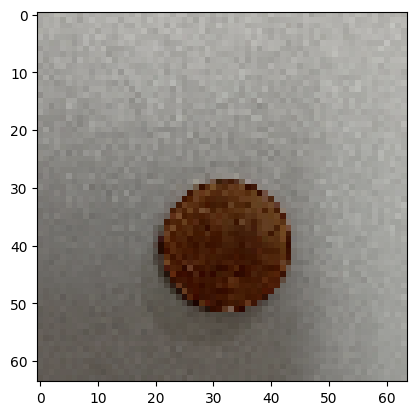

moeda reconhecida: 5


In [3]:
folder = '../datasetNovoComAntigo'

image_width = 64
image_height = 64
channels = 3

train_files = []
i=0
for coin in ['5', '10', '25', '50', '100']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)
y_dataset = []

i = 0
for coin in ['5', '10', '25', '50', '100']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(coin)) if os.path.isfile(os.path.join(folder + '/' + str(coin), f))]
    for _file in onlyfiles:
  ###
        img = cv2.imread(os.path.join(folder, coin, _file))
        img_resized = cv2.resize(img, (image_width, image_height))

        dataset[i] = img_resized
        mapping = {'5': 0, '10': 1, '25': 2, '50': 3, '100': 4, }
        y_dataset.append(mapping[coin])
   ###

        i += 1
        if i % 250 == 0:
            print("%d images no array" % i)
print("Todas imagens no array!")

# normalizando os dados
dataset = dataset.astype('float32')
dataset /= 300

pixels = np.array(dataset[0], dtype='float32')
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()
plt.close()
n_classes = len(set(y_dataset))
print('moeda reconhecida:', n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

# Separando o modelo em 20% para teste e o restante para treino

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_dataset_, test_size=0.2)
print("Tamanho da pasta de treino: {0}, Tamanho da pasta de teste: {1}".format(len(X_train), len(X_test)))

Tamanho da pasta de treino: 2341, Tamanho da pasta de teste: 586


# Balancear o conujunto de imagens do dataset

In [5]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 500

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")


Tamanho do conjunto de treinamento balanceado: 2500
Tamanho do conjunto de teste: 586
Classe 0: 500 amostras
Classe 1: 500 amostras
Classe 2: 500 amostras
Classe 3: 500 amostras
Classe 4: 500 amostras


# Aumentação de dados
Usado para aumentar a quantidade e a diversidade dos dados de treinamento.

In [6]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=90, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')
datagen.fit(X_train)

# Construção do modelo
Construindo o modelo em uma rede neural convolucional(CNN) para classificar moedas.

In [7]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(64, 64, 3)))
model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 32, kernel_size=(2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 128, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(units = 5, activation='softmax', name = 'saida'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 64, 64, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)       

# Compilação do modelo

In [8]:
# Taxa de aprendizado
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
# Parada antecipada
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

# Treinando o modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks = [early_stopping])


Epoch 1/100


59/59 [==============================] - 10s 153ms/step - loss: 1.1865 - accuracy: 0.5187 - val_loss: 1.2944 - val_accuracy: 0.6119
Epoch 2/100
59/59 [==============================] - 9s 147ms/step - loss: 0.8233 - accuracy: 0.6741 - val_loss: 1.0635 - val_accuracy: 0.7676
Epoch 3/100
59/59 [==============================] - 9s 153ms/step - loss: 0.6671 - accuracy: 0.7399 - val_loss: 0.8716 - val_accuracy: 0.7527
Epoch 4/100
59/59 [==============================] - 9s 154ms/step - loss: 0.5949 - accuracy: 0.7751 - val_loss: 0.7203 - val_accuracy: 0.7249
Epoch 5/100
59/59 [==============================] - 9s 156ms/step - loss: 0.5233 - accuracy: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8145
Epoch 6/100
59/59 [==============================] - 9s 153ms/step - loss: 0.4220 - accuracy: 0.8408 - val_loss: 0.4050 - val_accuracy: 0.8443
Epoch 7/100
59/59 [==============================] - 9s 158ms/step - loss: 0.3647 - accuracy: 0.8536 - val_loss: 0.2974 - val_accuracy: 0.8

# Plotagem do gráfico da função Perda X Épocas

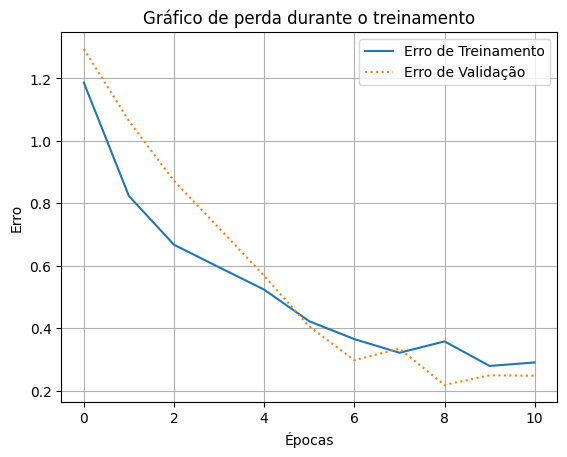

In [10]:
# Gráfico de treinamento e validação da função perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ':')
plt.title('Gráfico de perda durante o treinamento')
#plt.yscale('log')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Erro de Treinamento', 'Erro de Validação'])
plt.grid(True)
plt.show()

# Plotagem do gráfico da função Acurácia X Épocas

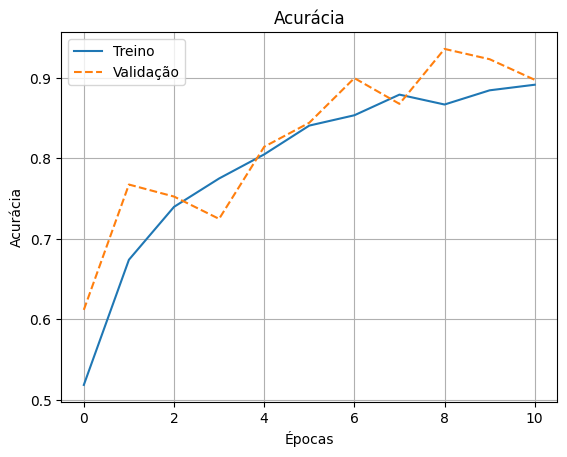

In [11]:
# Plotando o treinamento e a validação da accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
#plt.yscale("log")
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'])
plt.grid(True)
plt.show()

# Resultado das predições

19/19 [==============================] - 1s 30ms/step


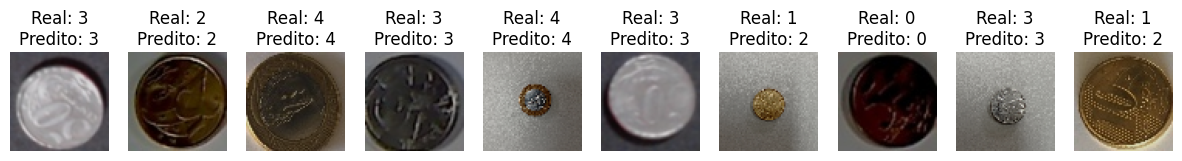

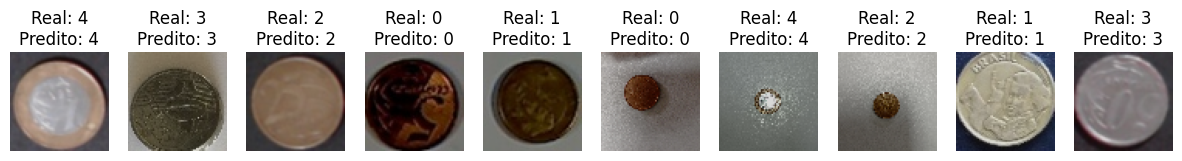

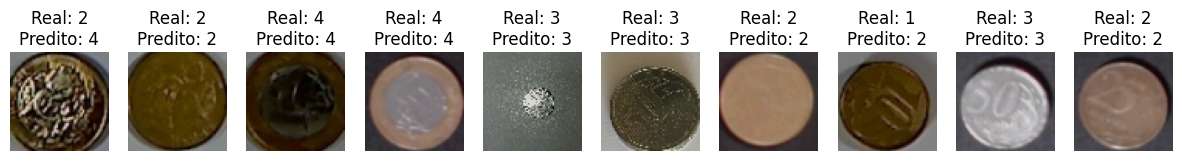

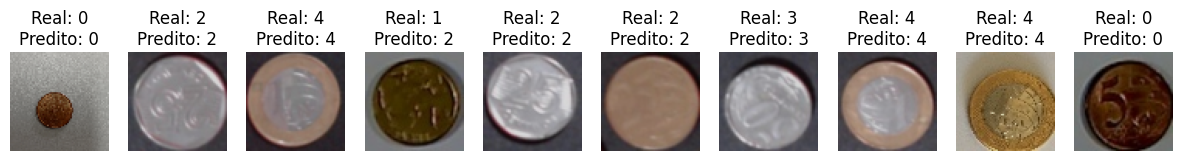

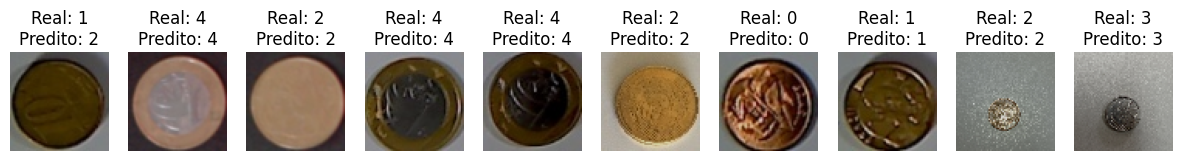

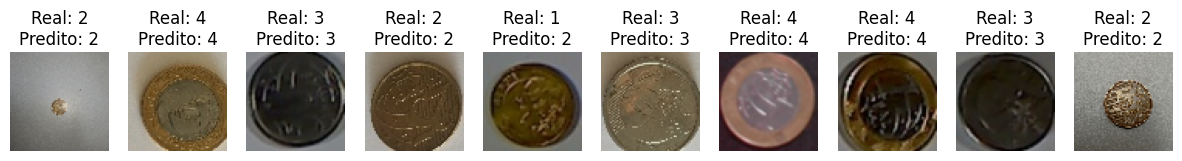

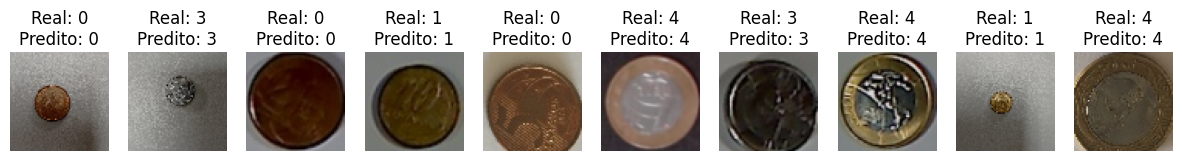

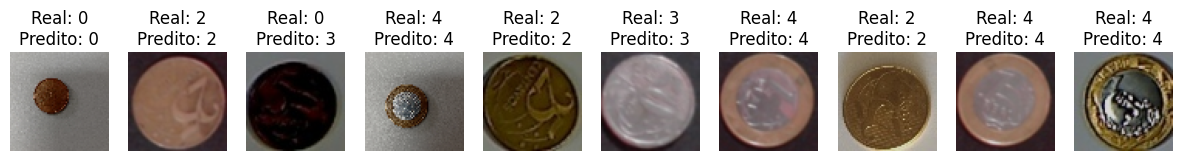

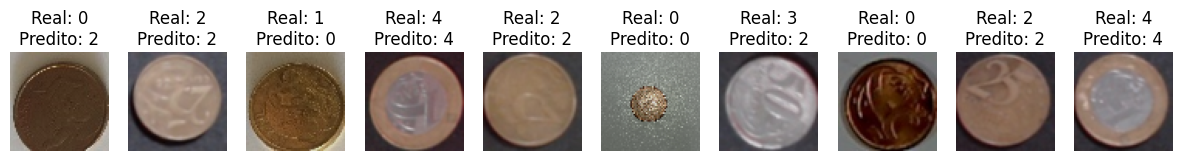

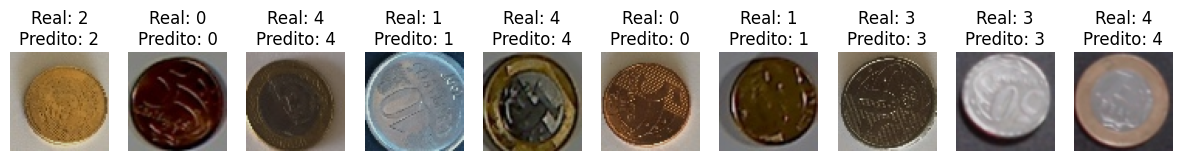

In [12]:
preds = model.predict(X_test)

n = 10
for t in range(10):
    plt.figure(figsize=(15,15))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()

# Criando gráfico da matriz de confusão

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão normalizada")
    else:
        print('Matriz de Confusão, sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')

# Plotando gráfico da matriz de confusão

Matriz de Confusão, sem normalização
[[ 72   1   5   4   0]
 [  4  61  26   8   0]
 [  1   5 132   1   1]
 [  0   0   3 134   1]
 [  0   0   1   0 126]]


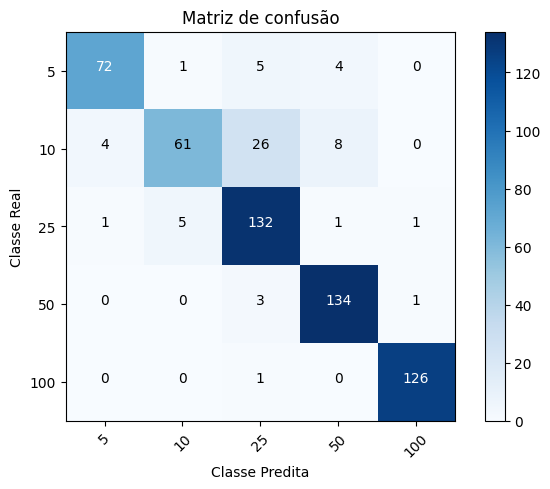

In [14]:
# Convertendo as previsões e os rótulos de volta para as classes originais
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

# Gerando gráfico
cm = confusion_matrix(y_test_, preds_)
plt.figure()
plot_confusion_matrix(cm, classes=['5', '10', '25', '50', '100'], title='Matriz de confusão')
plt.show()

# Avaliando a Perda e Acurácia do modelo por %

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Perda: ", loss)
print("Acurácia: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 1s 31ms/step - loss: 0.2778 - accuracy: 0.8959
Perda:  0.27776584029197693
Acurácia: 89.59%


# Avaliando o modelo através métricas accruracy, Precision, Recall, F1

In [16]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy)

# Calcular precisão
precision = precision_score(y_test_, preds_, average='macro')
print("Precisão:", precision)

# Calcular recall
recall = recall_score(y_test_, preds_, average='macro')
print("Recall:", recall)

# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='macro')
print("F1-score:", f1)

Acurácia: 0.8959044368600683
Precisão: 0.9063742967571905
Recall: 0.8800416033024311
F1-score: 0.885824232225092


# Salvando o modelo

In [17]:
# saving model
#model.save('mode_acurracy90TesteDia30as23hrs.h5')

# Mostrar historico do treinamento

In [18]:
#dados = pd.DataFrame(history.history)
#dados.head(11)

# Salvar dados em um arquivo CSV

In [19]:
#dados.to_csv('loss.csv')